In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 25 17:11:08 2019

@author: mgelman
"""
#fafe
import csv
import itertools
import operator
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import graphviz
from scipy.sparse import hstack
from sklearn import tree
import pydot
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Loading In Data

In [12]:
# import data
path = os.path.join(os.path.expanduser("~"), "Documents", "lowe_house_price_prediction", "yelp_dataset")
#sys.path.insert(0, path)
#sys.path.insert(0, "C:\Users\mgelman\AppData\Local\Continuum\anaconda2\Library\bin\graphviz")

# LOAD BUSINESS DATA
inputfile = os.path.join(path, "business.json")
business_data = pd.read_json(inputfile, lines=True)
# keep a subset of variables
business_data = business_data[['business_id', 'postal_code', 'state', 'categories']]
# trim the category text
business_data['categories'] = business_data['categories'].str.slice(stop=50)
business_data['categories'] = business_data['categories'].str.encode('ascii', errors='coerce')
#business_data['categories'] = business_data['categories'].str.replace('&', '')

# convert postal code to integers (will get rid of non-us zipcodes)
business_data['postal_code'] = pd.to_numeric(business_data['postal_code'], errors='coerce')
business_data.dropna(inplace=True)

In [26]:
business_data.head(100)

,business_id,postal_code,state,categories
0,1SWheh84yJXfytovILXOAQ,85016.0,AZ,"b'Golf, Active Life'"
2,gnKjwL_1w79qoiV3IC_xQQ,28210.0,NC,"b'Sushi Bars, Restaurants, Japanese'"
3,xvX2CttrVhyG2z1dFg_0xw,85338.0,AZ,"b'Insurance, Financial Services'"
4,HhyxOkGAM07SRYtlQ4wMFQ,28217.0,NC,"b'Plumbing, Shopping, Local Services, Home Ser..."
7,gbQN7vr_caG_A1ugSmGhWg,89121.0,NV,"b""Hair Salons, Hair Stylists, Barbers, Men's H..."
...,...,...,...,...
130,DwsESfIDIsgQ4DTx9VNOsw,85016.0,AZ,"b'Home Services, Handyman, Painters, Contractors'"
131,faixHjogPjNUo07T0RBRFw,89118.0,NV,"b'Security Systems, Home Services'"
132,3aUBEB206LBNLUY6rCW2sw,85282.0,AZ,"b'Traditional Chinese Medicine, Health & Medic..."
133,ysfeDcLAYk_MVzfBmyiSTg,85007.0,AZ,"b'Restaurants, Food, Cafes'"


In [28]:
# LOAD IN REVIEW DATA (use unix command top to create a smaller version of the dataset)
# head -n NUMBEROFLINES file.json > mynewfile.json
# TO GET SPECIFIC YEAR
# grep -E '201[0|1|2]' review.json > review_2010-2012.json
# inputfile=os.path.join(path,"review.json")
inputfile = os.path.join(path, "review_10k.json")
outputfile = os.path.join(path, "review.pkl")
review_data = pd.read_json(inputfile, lines=True)
# only keep business_id, date, stars, text
review_data = review_data[['business_id', 'date', 'stars', 'text']]
# take out numbers in 'text'
review_data['text'] = review_data['text'].str.replace('[0-9]', '')

# vectorizer = TfidfVectorizer(ngram_range=(1, 1),
#                             stop_words='english',
#                             min_df=30)
# X_test= vectorizer.fit_transform(review_data['text'])
# names=vectorizer.get_feature_names()

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                            stop_words='english',
                            min_df=30)
X_test= vectorizer.fit_transform(review_data['text'])
names=vectorizer.get_feature_names()

In [83]:
inputfile = os.path.join(path, "Zip_Zhvi_AllHomes.csv")
# zillow_data = pd.read_csv(inputfile, header=0, quoting=3)
zillow_data = pd.read_csv(inputfile, encoding='latin-1')

In [84]:
zillow_data.head(100)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,168300.0,168400.0,168400.0,...,1054100,1032200,1019300,1014500,995100,978700,973800,975700,975700,973300
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,160000.0,161000.0,161700.0,...,353500,353500,354500,354300,352300,349700,347800,347200,346000,344500
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,353100.0,353700.0,354200.0,...,1380000,1375600,1376300,1369800,1364200,1375100,1403700,1413700,1415100,1422300
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,210400.0,212200.0,212200.0,...,335700,335100,334100,333500,333500,333400,331900,329600,327700,326700
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,194400.0,196100.0,197300.0,...,432600,433100,433800,432800,430700,428600,426000,423000,419900,419200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,79054,48197,Ypsilanti,MI,Ann Arbor,Washtenaw County,96,126900.0,127600.0,128400.0,...,222500,225000,227500,228300,228800,229300,229600,230000,230500,230900
96,77007,44107,Lakewood,OH,Cleveland-Elyria,Cuyahoga County,97,93700.0,94100.0,94500.0,...,188300,190100,192300,192400,189000,186400,187500,189300,190500,191800
97,87074,66062,Olathe,KS,Kansas City,Johnson County,98,107200.0,107400.0,107800.0,...,261300,262600,264200,265600,266400,266600,267000,267300,268300,269600
98,62022,11211,New York,NY,New York-Newark-Jersey City,Kings County,99,146000.0,146300.0,146500.0,...,961700,964600,969800,972700,974300,975900,977700,981100,982900,979800


In [85]:
# Drop some columns
zillow_data.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)
# Make it such that: RegionName is the only identifier, the others are variable year then then value 
zillow_data = pd.melt(zillow_data, id_vars='RegionName', value_vars=list(zillow_data.columns.values)[1:])

In [86]:
zillow_data.head(100)

,RegionName,variable,value
0,10025,1996-04,168300.0
1,60657,1996-04,160000.0
2,10023,1996-04,353100.0
3,77494,1996-04,210400.0
4,60614,1996-04,194400.0
...,...,...,...
95,48197,1996-04,126900.0
96,44107,1996-04,93700.0
97,66062,1996-04,107200.0
98,11211,1996-04,146000.0


In [87]:
# generate datetime
zillow_data['date'] = pd.to_datetime(zillow_data['variable'])
zillow_data['year'] = zillow_data['date'].dt.year

In [88]:
zillow_data.head(10)

,RegionName,variable,value,date,year
0,10025,1996-04,168300.0,1996-04-01,1996
1,60657,1996-04,160000.0,1996-04-01,1996
2,10023,1996-04,353100.0,1996-04-01,1996
3,77494,1996-04,210400.0,1996-04-01,1996
4,60614,1996-04,194400.0,1996-04-01,1996
5,77449,1996-04,95400.0,1996-04-01,1996
6,10002,1996-04,NaN,1996-04-01,1996
7,77084,1996-04,94700.0,1996-04-01,1996
8,79936,1996-04,77200.0,1996-04-01,1996
9,60640,1996-04,99400.0,1996-04-01,1996


In [89]:
# get yearly mean
zillow_yearly_avg = zillow_data.groupby(['RegionName', 'year'])['value'].mean().reset_index()

In [90]:
zillow_yearly_avg.head(10)

,RegionName,year,value
0,1001,1996,104900.000000
1,1001,1997,107283.333333
2,1001,1998,111050.000000
3,1001,1999,114000.000000
4,1001,2000,120416.666667
5,1001,2001,129525.000000
6,1001,2002,140400.000000
7,1001,2003,153458.333333
8,1001,2004,171991.666667
9,1001,2005,197291.666667


In [91]:
# %% Merge everyting together

# First merge the yelp data to get zipcode
yelp_merged = review_data.merge(business_data, left_on='business_id', right_on='business_id', how='left',
                                validate="m:1")
yelp_merged['year'] = pd.to_datetime(yelp_merged['date']).dt.year

In [92]:
yelp_merged.head(10)

,business_id,date,stars,text,postal_code,state,categories,year
0,ujmEBvifdJM6h6RLv4wQIg,2013-05-07 04:34:36,1,Total bill for this horrible service? Over $Gs...,89128.0,NV,"b'Fitness & Instruction, Doctors, Health & Med...",2013
1,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5,I *adore* Travis at the Hard Rock's new Kelly ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
2,WTqjgwHlXbSFevF32_DJVw,2016-11-09 20:09:03,5,I have to say that this office really has it t...,85286.0,AZ,"b'Health & Medical, Cosmetic Dentists, Orthodo...",2016
3,ikCg8xy5JIg_NGPx-MSIDA,2018-01-09 20:56:38,5,Went in for a lunch. Steak sandwich was delici...,NaN,NaN,NaN,2018
4,b1b1eb3uo-w561D0ZfCEiQ,2018-01-30 23:07:38,1,Today was my second out of three sessions I ha...,85251.0,AZ,"b'Teeth Whitening, Beauty & Spas'",2018
5,eU_713ec6fTGNO4BegRaww,2013-01-20 13:25:59,4,I'll be the first to admit that I was not exci...,15211.0,PA,"b'Restaurants, Italian, Pizza'",2013
6,3fw2X5bZYeW9xCz_zGhOHg,2016-05-07 01:21:02,3,Tracy dessert had a big name in Hong Kong and ...,NaN,NaN,NaN,2016
7,zvO-PJCpNk4fgAVUnExYAA,2010-10-05 19:12:35,1,This place has gone down hill. Clearly they h...,85254.0,AZ,"b'Sports Bars, Bars, Restaurants, American (Ne...",2010
8,b2jN2mm9Wf3RcrZCgfo1cg,2015-01-18 14:04:18,2,I was really looking forward to visiting after...,44113.0,OH,"b'Breweries, Event Planning & Services, Pubs, ...",2015
9,oxwGyA17NL6c5t1Etg5WgQ,2012-02-29 21:52:43,3,It's a giant Best Buy with registers. I don'...,89119.0,NV,"b'Shopping, Computers, Electronics, Mobile Pho...",2012


In [93]:
# merge yelp with zillow
final_data = yelp_merged.merge(zillow_yearly_avg, left_on=['postal_code', 'year'], right_on=['RegionName', 'year'],
                               how='left', validate="m:1")
final_data.dropna(inplace=True)

#csv_file_name = os.path.join(path, "yelp_zillow.tsv")
#final_data[['year', 'stars', 'postal_code', 'state', 'value']].to_csv(csv_file_name, sep='\t', encoding='utf-8',
#                                                                      index=False, quoting=csv.QUOTE_NONE)

In [94]:
final_data.head(10)

,business_id,date,stars,text,postal_code,state,categories,year,RegionName,value
0,ujmEBvifdJM6h6RLv4wQIg,2013-05-07 04:34:36,1,Total bill for this horrible service? Over $Gs...,89128.0,NV,"b'Fitness & Instruction, Doctors, Health & Med...",2013,89128.0,143991.666667
1,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5,I *adore* Travis at the Hard Rock's new Kelly ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.000000
2,WTqjgwHlXbSFevF32_DJVw,2016-11-09 20:09:03,5,I have to say that this office really has it t...,85286.0,AZ,"b'Health & Medical, Cosmetic Dentists, Orthodo...",2016,85286.0,327025.000000
4,b1b1eb3uo-w561D0ZfCEiQ,2018-01-30 23:07:38,1,Today was my second out of three sessions I ha...,85251.0,AZ,"b'Teeth Whitening, Beauty & Spas'",2018,85251.0,324441.666667
5,eU_713ec6fTGNO4BegRaww,2013-01-20 13:25:59,4,I'll be the first to admit that I was not exci...,15211.0,PA,"b'Restaurants, Italian, Pizza'",2013,15211.0,68616.666667
7,zvO-PJCpNk4fgAVUnExYAA,2010-10-05 19:12:35,1,This place has gone down hill. Clearly they h...,85254.0,AZ,"b'Sports Bars, Bars, Restaurants, American (Ne...",2010,85254.0,291175.000000
11,mRUVMJkUGxrByzMQ2MuOpA,2017-12-15 23:27:08,1,"Walked in around on a Friday afternoon, we sa...",85209.0,AZ,"b'Restaurants, Breakfast & Brunch, Burgers, Am...",2017,85209.0,239233.333333
12,FxLfqxdYPA6Z85PFKaqLrg,2016-05-07 01:36:53,4,Wow. So surprised at the one and two star revi...,15241.0,PA,"b'Italian, Salad, Restaurants, Gluten-Free'",2016,15241.0,273908.333333
13,LUN6swQYa4xJKaM_UEUOEw,2018-04-27 20:25:26,4,Michael from Red Carpet VIP is amazing ! I rea...,89109.0,NV,"b'Hotels & Travel, Travel Services, Nightlife,...",2018,89109.0,328966.666667
16,NyLYY8q1-H3hfsTwuwLPCg,2015-01-03 22:47:34,4,Great lunch today. Staff was very helpful in a...,44122.0,OH,"b'Fast Food, Vegetarian, Restaurants, Vegan, I...",2015,44122.0,203458.333333


# Aggregate and Create Differences

In [109]:
# First aggregate to zip year
# create the dictionary for the collapse (mapping from var to agg type)

# group by creates a mapping from the user_id to the row index. Ie, user 1 maps to rows 4,5,6, user 2 maps to rows 7,8,9.
data_group = final_data.groupby(['postal_code', 'year'], as_index=False)

In [110]:
# aggregate in groups depending on the var type
# group 1: numerical variables
mean = ['value', 'stars']

# group 2: retain all strings
all = ['text']

# group 3: ID vars: like state
first = ['state']

# create the dictionary for the collapse (mapping from var to agg type)
d = {}
d_agg_type = {'first': first,
              np.nanmean: mean,
              lambda x: " ".join(x): all}

In [111]:
d_agg_type.items()

dict_items([('first', ['state']), (<function nanmean at 0x103c47598>, ['value', 'stars']), (<function <lambda> at 0x1a1605bae8>, ['text'])])

In [112]:
#key is the function, value is the column names 
for key, value in d_agg_type.items():
    for col in value:
        d.update({col: key})

In [113]:
#specify the way of aggregartion per column
d

{'state': 'first',
 'value': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'stars': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'text': <function __main__.<lambda>(x)>}

In [114]:
# collapse data
final_data_collapsed = data_group.agg(d)

In [115]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text
0,15003.0,2018,PA,79450.000000,5.00,Best place to get ice cream. They have only tw...
1,15017.0,2013,PA,132300.000000,4.00,Very good burgers and fries. The bun was just...
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...
3,15017.0,2016,PA,152375.000000,4.00,I have NEVER had a bad meal there! Larissa has...
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...
6,15037.0,2013,PA,90425.000000,3.00,My friend and I went to Becky's Place for a la...
7,15044.0,2014,PA,222275.000000,4.00,This Goodwill is an absolute gem for women's c...
8,15044.0,2016,PA,245650.000000,2.00,I want to start by saying that the staff there...
9,15045.0,2016,PA,33233.333333,1.00,Sounds like things haven't changed. Bad servic...


In [116]:
# create log prices
final_data_collapsed['log_price'] = np.log(final_data_collapsed['value'])

# NEED TO SORT TO GET DIFF
final_data_collapsed.sort_values(['postal_code', 'year'], inplace=True)

# convert words to word differences
vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                             stop_words='english',
                             min_df=30)
X_test = vectorizer.fit_transform(final_data_collapsed['text'])

In [107]:
# add the zipcode and year to the words
word_df = pd.concat([final_data_collapsed[['postal_code', 'year']], pd.DataFrame(X_test.todense())], axis=1)
# take the difference
word_df = word_df.groupby(['postal_code']).diff()

In [108]:
word_df.head(10)

,year,0,1,2,3,4,5,6,7,8,...,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0703,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,-0.0703,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.136873,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.0,0.0,-0.292396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# only keep one year difference
word_df = word_df.loc[word_df['year'] == 1]
# drop the column and covert back to sparse matrix
word_df.drop(['year'], axis=1, inplace=True)
X_words = scipy.sparse.csr_matrix(word_df.values)

In [125]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price
0,15003.0,2018,PA,79450.000000,5.00,Best place to get ice cream. They have only tw...,11.282883
1,15017.0,2013,PA,132300.000000,4.00,Very good burgers and fries. The bun was just...,11.792827
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...,11.836939
3,15017.0,2016,PA,152375.000000,4.00,I have NEVER had a bad meal there! Larissa has...,11.934100
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...,11.996226
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...,12.046930
6,15037.0,2013,PA,90425.000000,3.00,My friend and I went to Becky's Place for a la...,11.412276
7,15044.0,2014,PA,222275.000000,4.00,This Goodwill is an absolute gem for women's c...,12.311671
8,15044.0,2016,PA,245650.000000,2.00,I want to start by saying that the staff there...,12.411663
9,15045.0,2016,PA,33233.333333,1.00,Sounds like things haven't changed. Bad servic...,10.411309


In [127]:
# sort by postal_code, year
final_data_collapsed[['D_LP', 'D_stars', 'D_year']] = final_data_collapsed.groupby(['postal_code'])[
    'log_price', 'stars', 'year'].diff()
# only keep if the difference in year is 1. Or else we are missing data
final_data_collapsed = final_data_collapsed.loc[final_data_collapsed['D_year'] == 1]  # type: object

In [128]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price,D_LP,D_stars,D_year
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...,11.836939,0.044112,-0.50,1.0
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...,11.996226,0.062126,-0.50,1.0
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...,12.046930,0.050705,-0.75,1.0
15,15084.0,2015,PA,75633.333333,3.00,Johnny Rockets is a decent choice for a weeken...,11.233652,0.194203,-2.00,1.0
19,15090.0,2015,PA,299491.666667,3.00,"I get mani/pedis, waxing and lashes. \nThe tec...",12.609842,0.051207,-0.75,1.0
20,15090.0,2016,PA,320266.666667,1.00,"First, I would like to say that this review do...",12.676909,0.067067,-2.00,1.0
21,15090.0,2017,PA,336175.000000,1.00,i've had nothing but bad experiences here. the...,12.725387,0.048478,0.00,1.0
23,15101.0,2017,PA,228033.333333,3.00,I am very excited to have a Thai restaurant no...,12.337247,0.061726,-2.00,1.0
24,15101.0,2018,PA,241741.666667,5.00,I've been going to Image Nails for over years...,12.395625,0.058378,2.00,1.0
26,15102.0,2016,PA,174225.000000,1.00,I went into this salon at on a Wednesday even...,12.068103,0.026561,-3.00,1.0


In [ ]:
# Create P_LD categories
final_data_collapsed['P_LD_CAT'] = pd.qcut(final_data_collapsed['D_LP'].values, 5).codes

In [135]:
# confirm the correct split
final_data_collapsed['P_LD_CAT'].value_counts(normalize=True, sort=False)

0    0.20068
1    0.19983
2    0.19983
3    0.19983
4    0.19983
Name: P_LD_CAT, dtype: float64

In [134]:
# log price describe
final_data_collapsed['D_LP'].describe()

count    1176.000000
mean        0.064959
std         0.089294
min        -0.542478
25%         0.039857
50%         0.069175
75%         0.103840
max         0.331314
Name: D_LP, dtype: float64

In [129]:
# state data distribution 
final_data_collapsed['state'].value_counts(normalize=True, sort=True)

AZ    0.417517
NV    0.227041
NC    0.122449
OH    0.106293
PA    0.079932
WI    0.028061
IL    0.012755
SC    0.005952
Name: state, dtype: float64

In [132]:
pd.qcut(final_data_collapsed['D_LP'].values, 5)

[(0.0303, 0.0598], (0.0598, 0.0823], (0.0303, 0.0598], (0.114, 0.331], (0.0303, 0.0598], ..., (0.114, 0.331], (0.0598, 0.0823], (0.0823, 0.114], (0.114, 0.331], (0.114, 0.331]]
Length: 1176
Categories (5, interval[float64]): [(-0.543, 0.0303] < (0.0303, 0.0598] < (0.0598, 0.0823] < (0.0823, 0.114] < (0.114, 0.331]]

In [130]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price,D_LP,D_stars,D_year,P_LD_CAT
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...,11.836939,0.044112,-0.50,1.0,1
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...,11.996226,0.062126,-0.50,1.0,2
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...,12.046930,0.050705,-0.75,1.0,1
15,15084.0,2015,PA,75633.333333,3.00,Johnny Rockets is a decent choice for a weeken...,11.233652,0.194203,-2.00,1.0,4
19,15090.0,2015,PA,299491.666667,3.00,"I get mani/pedis, waxing and lashes. \nThe tec...",12.609842,0.051207,-0.75,1.0,1
20,15090.0,2016,PA,320266.666667,1.00,"First, I would like to say that this review do...",12.676909,0.067067,-2.00,1.0,2
21,15090.0,2017,PA,336175.000000,1.00,i've had nothing but bad experiences here. the...,12.725387,0.048478,0.00,1.0,1
23,15101.0,2017,PA,228033.333333,3.00,I am very excited to have a Thai restaurant no...,12.337247,0.061726,-2.00,1.0,2
24,15101.0,2018,PA,241741.666667,5.00,I've been going to Image Nails for over years...,12.395625,0.058378,2.00,1.0,1
26,15102.0,2016,PA,174225.000000,1.00,I went into this salon at on a Wednesday even...,12.068103,0.026561,-3.00,1.0,0


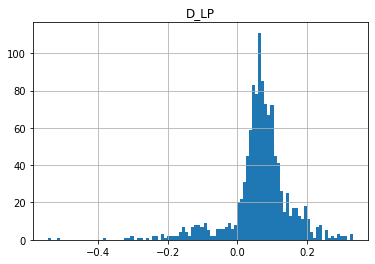

In [8]:
# histogram
final_data_collapsed.hist(column='D_LP', bins=100)
plt.show()
del review_data, business_data, zillow_data

# Models

Normalized confusion matrix
[[0.13 0.14 0.23 0.26 0.24]
 [0.14 0.25 0.15 0.2  0.26]
 [0.19 0.25 0.24 0.19 0.14]
 [0.24 0.14 0.27 0.22 0.14]
 [0.2  0.16 0.22 0.22 0.18]]
("b'place'", 0.026873362486360797)
('stars', 0.020914230254232183)
("b'tomato'", 0.019500091184128546)
("b'good'", 0.019124995985751563)
("b'just'", 0.016654907113775052)
("b'great'", 0.016094374844261357)
("b'ordered'", 0.015565255511641594)
("b'got'", 0.014403520312843338)
("b'services'", 0.01415441189182241)
("b'shop'", 0.013414711045242335)
("b'say'", 0.013220545654962583)
("b'person'", 0.012964957564760907)
("b'don'", 0.012243244612545624)
("b'left'", 0.012229241425177697)
("b'order'", 0.011698437114640858)
("b'going'", 0.011674493301304644)
("b'nice'", 0.011547236205653243)
("b'fried'", 0.010748629588442847)
("b'way'", 0.010714349312188677)
("b'fun'", 0.010038732129594745)

the training_score is 1.0

the testing_score is 0.20068027210884354


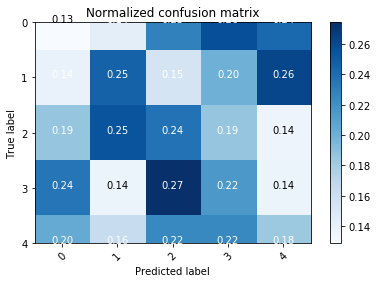

In [142]:
# use one hot encoding
# final_data = pd.concat([final_data,pd.get_dummies(final_data['categories'])],axis=1)

# test=pd.get_dummies(final_data['categories'])

# %% Create testing,training dataset

# data.to_pickle(outputfile)

# define y as the stars and X as text
# y_data=final_data['value']
y_data = final_data_collapsed['P_LD_CAT']
# X_data=final_data[['stars','text']]
# X_data=final_data[['stars','text','categories']]
X_data = final_data_collapsed[['D_stars']]
# print y_data.value_counts(normalize=True, sort=False)

# split into training and test
X_train, X_test, y_train, y_test, X_words_train, X_words_test = train_test_split(
    X_data, y_data, X_words, test_size=0.25, random_state=1234)

vocab = vectorizer.get_feature_names()
vocab_str = [str(x.encode('utf-8')) for x in vocab]

# Add in stars and yelp categories as features
X_tr = hstack([X_words_train, np.matrix(X_train)])
X_te = hstack([X_words_test, np.matrix(X_test)])

# %%

# falsification test
# y_train=y_train.sample(frac=1)

# Use the tree clasifier
# clf = DecisionTreeRegressor(max_leaf_nodes=15)
clf = DecisionTreeClassifier()
# clf = DecisionTreeClassifier()
# clf = DecisionTreeRegressor()
# clf = RandomForestClassifier(
#                n_estimators=128,
#                n_jobs=-1,
#                verbose=1)

# clf = DecisionTreeClassifier(max_leaf_nodes=15)

clf = clf.fit(X_tr, y_train)

# check which words are the most frequent
# sum_words = X_tr.sum(axis=0)
# words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
# words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
# 
##Look a Top X frequent words
# for word, freq in words_freq[:10]:
#    print(word, freq)  


y_pred = clf.predict(X_te)

# confusion matrix
# create label
price_label = [0, 1, 2, 3, 4]
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, classes=price_label, normalize=True, title='Normalized confusion matrix')

# print cm
# print cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# features are the text labels, then STARS, then the yelp categories
# feat_str=vocab_str+["stars"]+list(X_train.columns.values)[2:]
feat_str = vocab_str + ["stars"]
dictionary = dict(zip(feat_str, clf.feature_importances_))
sorted_x = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
for x in range(20):
    print(sorted_x[x])

# overall score
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

# %%
# Graph the tree
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Normalized confusion matrix
[[0.14 0.14 0.23 0.27 0.21]
 [0.12 0.23 0.2  0.2  0.25]
 [0.19 0.2  0.22 0.22 0.17]
 [0.24 0.14 0.29 0.22 0.12]
 [0.14 0.14 0.22 0.29 0.2 ]]
("b'good'", 0.019786689767501933)
("b'tomato'", 0.019500091184128546)
('stars', 0.018633620053552534)
("b'going'", 0.014292182987350063)
("b'services'", 0.014154411891822411)
("b'just'", 0.014008131986773574)
("b'better'", 0.013812498715154577)
("b'person'", 0.0130832125997424)
("b'staff'", 0.012248906697005357)
("b'don'", 0.012243244612545626)
("b'left'", 0.012229241425177699)
("b've'", 0.01200708873012062)
("b'got'", 0.011825492591738002)
("b'order'", 0.011698437114640858)
("b'nice'", 0.011547236205653245)
("b'shop'", 0.01135535794897843)
("b'great'", 0.01114530528158174)
("b'ordering'", 0.010158562622422282)
("b'break'", 0.009981025287275666)
("b'check'", 0.009799596387341944)

the training_score is 1.0

the testing_score is 0.20068027210884354

the training_score is 0.2108843537414966

the testing_score is 0.1666666

//anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
//anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LinearDiscriminantAnalysis
****Results****
Accuracy: 20.0680%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 22.4490%
DecisionTreeClassifier
****Results****
Accuracy: 20.7483%
RandomForestClassifier
****Results****


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


Accuracy: 23.1293%
AdaBoostClassifier
****Results****
Accuracy: 20.0680%
GradientBoostingClassifier
****Results****
Accuracy: 26.8707%
                      Classifier   Accuracy
0     GradientBoostingClassifier  26.870748
0           KNeighborsClassifier  26.530612
0         RandomForestClassifier  23.129252
0  QuadraticDiscriminantAnalysis  22.448980
0         DecisionTreeClassifier  20.748299
0     LinearDiscriminantAnalysis  20.068027
0             AdaBoostClassifier  20.068027
0                      LinearSVC  15.646259


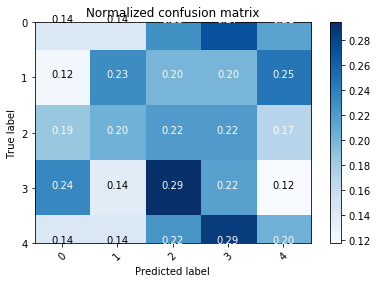

In [11]:
dot_data = StringIO()
# graphfile=os.path.join(path,"fig","graph_v2.dot")
# tree.export_graphviz(clf, out_file=graphfile,
tree.export_graphviz(clf, out_file=dot_data,
                     feature_names=feat_str,
                     filled=True, rounded=True, special_characters=True,
                     # proportion=True
                     )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graphfile = os.path.join(path, "fig", "graph_v2.pdf")
graph.write_pdf(graphfile)

# %%
# from sklearn.naive_bayes import MultinomialNB
#
# clf = MultinomialNB().fit(X_tr, y_train)  # classifying transformed text data to target value
#
# # confusion matrix
# y_pred = clf.predict(X_te)
# # cm=confusion_matrix(y_test, y_pred)
# # np.set_printoptions(precision=2)
# # plot_confusion_matrix(cm, classes=star_label,normalize=True,title='Normalized confusion matrix')
#
#
# # calculating the mean accuracy on the given test data and labels
# training_score = clf.score(X_tr, y_train, sample_weight=None)
# testing_score = clf.score(X_te, y_test, sample_weight=None)
# print()
# print("the training_score is " + str(training_score))
# print()
# print("the testing_score is " + str(testing_score))
#
# neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
# pos_class_prob_sorted = clf.feature_log_prob_[4, :].argsort()
#
# print(np.take(feat_str, neg_class_prob_sorted[-10:]))
# print(np.take(feat_str, pos_class_prob_sorted[-10:]))

# %%
# from sklearn.svm import LinearSVC
#
# clf = LinearSVC().fit(X_tr, y_train)  # classifying transformed text data to target value
#
# # confusion matrix
# y_pred = clf.predict(X_te)
# cm = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)
# plot_confusion_matrix(cm, classes=price_label, normalize=True, title='Normalized confusion matrix')
#
# # calculating the mean accuracy on the given test data and labels
# training_score = clf.score(X_tr, y_train, sample_weight=None)
# testing_score = clf.score(X_te, y_test, sample_weight=None)
# print()
# print("the training_score is " + str(training_score))
# print()
# print("the testing_score is " + str(testing_score))
#
#
# def plot_coefficients(classifier, feature_names, top_features=10):
#     lowstar_coef = classifier.coef_[0, :] * -1
#     highstar_coef = classifier.coef_[4, :]
#     top_positive_coefficients = np.argsort(highstar_coef)[-top_features:]
#     top_negative_coefficients = np.argsort(lowstar_coef)[:top_features]
#     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
#     # create plot
#     plt.figure(figsize=(15, 5))
#     colors = ['red' if c < 0 else 'blue' for c in
#               np.hstack([lowstar_coef[top_negative_coefficients], highstar_coef[top_positive_coefficients]])]
#     plt.bar(np.arange(2 * top_features),
#             np.hstack([lowstar_coef[top_negative_coefficients], highstar_coef[top_positive_coefficients]]),
#             color=colors)
#     feature_names = np.array(feature_names)
#     plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60)
#     plt.show()
#
#
# plot_coefficients(clf, feat_str)
# # plot_coefficients(clf, vocab,star_type=4)


# %%
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

clf = clf.fit(X_tr, y_train)

# calculating the mean accuracy on the given test data and labels
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

# %% Compare all the different types

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    LinearSVC(),
    # NuSVC(probability=True),
    # GaussianNB(),
    # MultinomialNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=8, n_jobs=-1, verbose=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

denseclass = ['GaussianNB', 'LinearDiscriminantAnalysis', 'QuadraticDiscriminantAnalysis']

for clf in classifiers:

    name = clf.__class__.__name__
    if name in denseclass:
        X_train = X_tr.toarray()
        X_test = X_te.toarray()
    else:
        X_train = X_tr
        X_test = X_te

    clf.fit(X_train, y_train)

    print("=" * 30)
    print(name)

    print('****Results****')
    acc = clf.score(X_test, y_test, sample_weight=None)
    print("Accuracy: {:.4%}".format(acc))

    log_entry = pd.DataFrame([[name, acc * 100]], columns=log_cols)
    log = log.append(log_entry)

print("=" * 30)

print(log.sort_values(by='Accuracy', ascending=False))